In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 8.1 MB/s 
     |████████████████████████████████| 180 kB 75.7 MB/s 
     |████████████████████████████████| 97 kB 7.6 MB/s 
     |████████████████████████████████| 140 kB 63.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=0ae0da6490a85e432249e16023d8cc2676cce06131d6fafa376c2b916ea4740e
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=cd363ba39eba80f40a4c7b231719bd79c2fcfec5b3875963562d540f57c5b1fa
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [3]:
import os
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow
from glob import glob
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import tensorflow as tf
import cv2 as cv
import nibabel as nib

# Link data


In [4]:
datalink = '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/'
TRAIN = datalink + 'train/'
TEST = datalink + 'test/'

In [5]:
!ls {datalink} | grep ".csv"

sample_submission.csv
test.csv
test_meta.csv
train_256.csv
train_debug.csv
train_merge.csv
train_meta.csv


In [6]:
train_df = pd.read_csv(datalink + 'train_256.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [7]:
dim = 256

In [8]:
train_df['image_path'] = [('/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/train/' + train_df['image_id'][i] + '.png') for i in range(len(train_df))]
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...


# Only 14 classes

In [9]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...


# Preprocessing

In [10]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']

train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.563462,0.686216,0.462500,0.195205,0.090283
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.623915,0.305903,0.150608,0.095833,0.014433
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.309843,0.128581,0.125984,0.024740,0.003117
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.773523,0.472407,0.368053,0.753033,0.277156
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.239875,0.721145,0.045950,0.039368,0.001809


In [11]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_df[features]
y = train_df['class_id']
X.shape, y.shape

((36096, 9), (36096,))

In [12]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

# K-fold

In [13]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.563462,0.686216,0.462500,0.195205,0.090283,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.623915,0.305903,0.150608,0.095833,0.014433,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.309843,0.128581,0.125984,0.024740,0.003117,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.773523,0.472407,0.368053,0.753033,0.277156,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,/content/drive/MyDrive/COURSES/CS431/CXR-Abnor...,0.239875,0.721145,0.045950,0.039368,0.001809,4


In [14]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(3515, 879)

In [15]:
# # os.makedirs('/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/labels/train', exist_ok = True)
# # os.makedirs('/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/labels/val', exist_ok = True)
# # os.makedirs('/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/images/train', exist_ok = True)
# # os.makedirs('/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/images/val', exist_ok = True)
# label_dir = '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/archive/labels/'
# for file in tqdm(train_files):
#     shutil.copy(file, '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/images/train/')
#     filename = file.split('/')[-1].split('.')[0]
#     shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/labels/train')
        
# for file in tqdm(val_files):
#     shutil.copy(file, '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/images/val/')
#     filename = file.split('/')[-1].split('.')[0]
#     shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/labels/val')

# Get class name

In [16]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

# YOLOv5

In [17]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10081, done.
remote: Total 10081 (delta 0), reused 0 (delta 0), pack-reused 10081
Receiving objects: 100% (10081/10081), 10.41 MiB | 25.02 MiB/s, done.
Resolving deltas: 100% (6987/6987), done.
/content/yolov5


In [18]:
!pip install -r requirements.txt # install dependencies
import torch
from IPython.display import Image, clear_output  # to display images
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


## Train

In [19]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'yolov5.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'yolov5.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/train.txt
val: /content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/val.txt



In [20]:
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-113-g5ca5dd4 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅


In [21]:
!WANDB_MODE="dryrun" python train.py --img 256 --batch 32 --epochs 30 --data '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/yolov5.yaml' --weights yolov5x.pt --cache

train: weights=yolov5x.pt, cfg=, data=/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/yolov5.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=32, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-113-g5ca5dd4 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamm

In [24]:
# !zip -r /content/yolov5.zip /content/yolov5

from google.colab import files
files.download("/content/yolov5-2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Dừng nha

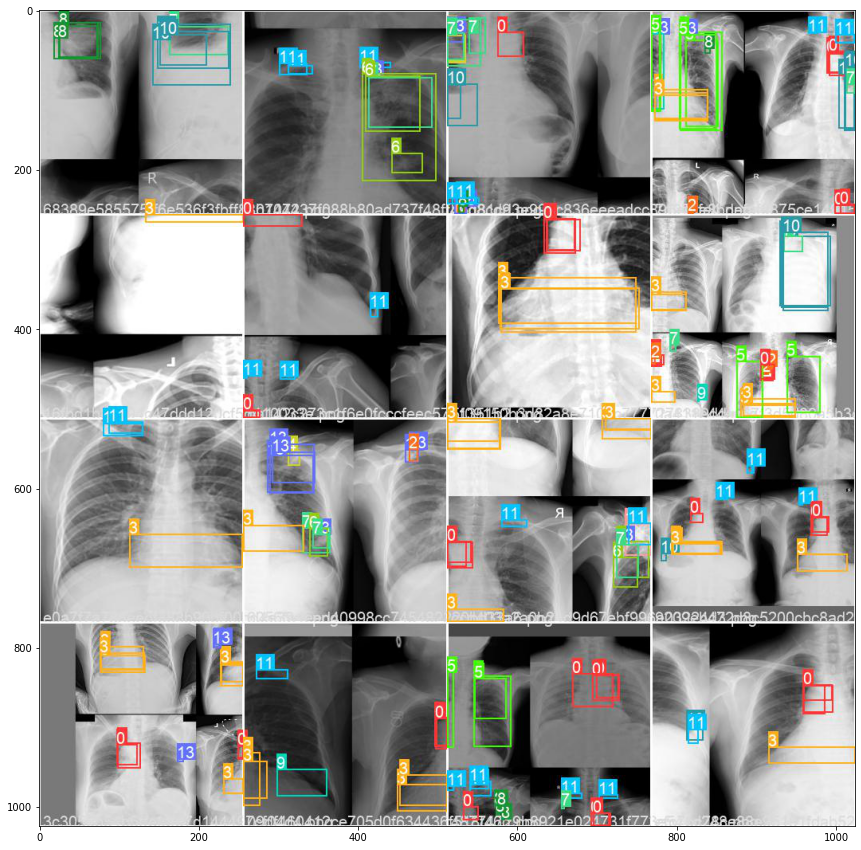

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch0.jpg'))
plt.savefig('fig1.png')
# plt.figure(figsize = (15, 15))
# plt.imshow(plt.imread('runs/train/exp2/train_batch1.jpg'))

# plt.figure(figsize = (15, 15))
# plt.imshow(plt.imread('runs/train/exp2/train_batch2.jpg'))

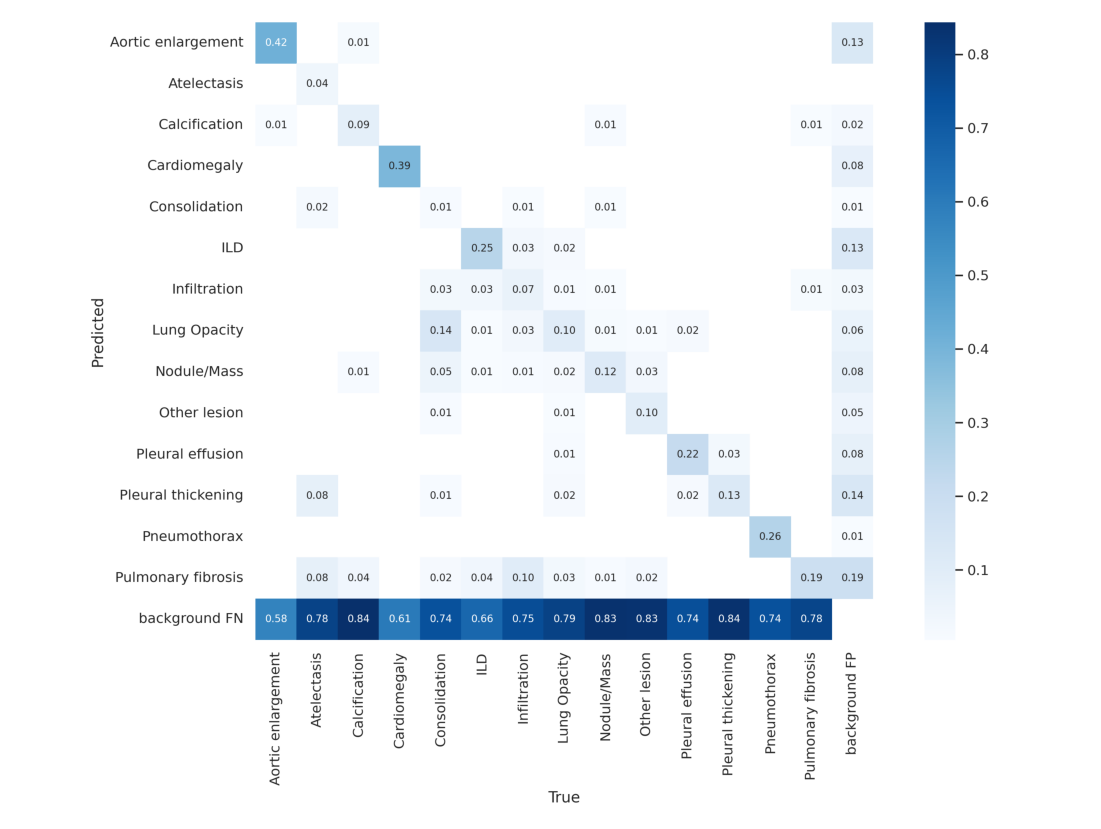

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

# Inference


In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --imgsz 256 \
--conf 0.15 \
--iou 0.5 \
--source '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/images/val/' \
--exist-ok

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/yolo/images/val/, imgsz=[256, 256], conf_thres=0.15, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-108-g53349da torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 444 layers, 86260891 parameters, 0 gradients, 204.2 GFLOPs
image 1/879 /content/drive/.shortcut-targets-by-id/1ScH0hjsInJJUGEX-k7MCjf15l7Kq0qcS/CXR-Abnormalities-Detection/data/yolo/images/val/00675cd546313f912cadd4ad54415d69.png: 256x256 1 Aortic enlargement, 1 Cardiomegaly, 1 Pleural thickening, Done. (0.061s)
image 2/879 /content/drive/.shortcut-targets-by-id/1ScH0hjsInJJU

## Test

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/test.csv')
test_df.head()

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376


In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt \
--img 256 \
--conf 0.01 \
--iou 0.4 \
--source '/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/test/' \
--save-txt --save-conf --exist-ok

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/COURSES/CS431/CXR-Abnormalities-Detection/data/test/, imgsz=[256, 256], conf_thres=0.01, iou_thres=0.4, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-108-g53349da torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 444 layers, 86260891 parameters, 0 gradients, 204.2 GFLOPs
image 1/3000 /content/drive/.shortcut-targets-by-id/1ScH0hjsInJJUGEX-k7MCjf15l7Kq0qcS/CXR-Abnormalities-Detection/data/test/002a34c58c5b758217ed1f584ccbcfe9.png: 256x256 1 Aortic enlargement, 1 Cardiomegaly, 1 ILD, 6 Pleural thickenings, Done. (0.064s)
image 2/3000 /content/drive/.shortcut-targets-by-id/1ScH0hjsInJJUGEX-k7MCjf15l7

In [ ]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

In [ ]:
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob('runs/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

  0%|          | 0/2997 [00:00<?, ?it/s]

In [ ]:
pred_df = pd.DataFrame({'image_id':image_ids,
                        'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, pred_df, on = 'image_id', how = 'left').fillna("14 1 0 0 1 1")
sub_df = sub_df[['image_id', 'PredictionString']]
sub_df.to_csv('submission.csv',index = False)
sub_df.tail()

,image_id,PredictionString
2995,7f5503caa936a623b4388fbd88e890c5,5 0.0 351 607 1104 1932 9 0.0 1600 1783 2312 2...
2996,c97e54a78bab9c05ce2e04fe6c284bcd,11 0.0 1980 588 2316 744 11 0.0 1032 588 1500 ...
2997,33218cf183c1224a74ccfb514e827e15,11 0.0 1798 587 1980 798 7 0.0 1643 499 1770 6...
2998,04b700c4815f088728db9f093c739707,11 0.0 1776 574 2018 766 11 0.0 1494 551 1727 ...
2999,14da9051525bd2504dd56938f92644ef,3 0.0 756 1405 1519 1680 11 0.0 1277 513 1472 ...


In [ ]:
# !zip -r /content/yolov5-2.zip /content/yolov5

# from google.colab import files
# files.download("/content/yolov5.zip")

updating: content/yolov5/ (stored 0%)
updating: content/yolov5/export.py (deflated 72%)
updating: content/yolov5/detect.py (deflated 67%)
updating: content/yolov5/Dockerfile (deflated 55%)
updating: content/yolov5/.pre-commit-config.yaml (deflated 61%)
updating: content/yolov5/.gitignore (deflated 55%)
updating: content/yolov5/__pycache__/ (stored 0%)
updating: content/yolov5/__pycache__/val.cpython-37.pyc (deflated 41%)
updating: content/yolov5/LICENSE (deflated 66%)
updating: content/yolov5/README.md (deflated 71%)
updating: content/yolov5/yolov5x.pt (deflated 8%)
updating: content/yolov5/.gitattributes (deflated 4%)
updating: content/yolov5/models/ (stored 0%)
updating: content/yolov5/models/__init__.py (stored 0%)
updating: content/yolov5/models/yolov5s.yaml (deflated 60%)
updating: content/yolov5/models/common.py (deflated 71%)
updating: content/yolov5/models/tf.py (deflated 70%)
updating: content/yolov5/models/yolov5l.yaml (deflated 61%)
updating: content/yolov5/models/__pycache_

FileNotFoundError: ignored